<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW6_prb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from google.colab import drive

drive.mount('/content/drive')
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)


plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

# Load diabetes dataset

file_path = '/content/drive/My Drive/ML/HW3/diabetes.csv'
df = pd.DataFrame(pd.read_csv(file_path))
df.head()
print(df.head())
print(df.shape)

# Features (X) and label (y)
X = df.drop('Outcome', axis=1).values.astype(np.float32)
y = df['Outcome'].values.astype(np.float32)

# Train / validation split (80/20)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=0, stratify=y
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Mounted at /content/drive
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
(768, 9)
Train shape: (614, 8) Val shape: (154, 8)


In [2]:
# Feature scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_val_scaled   = scaler.transform(X_val).astype(np.float32)

# Convert to PyTorch tensors & move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_tensor = torch.tensor(X_train_scaled, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), device=device)

X_val_tensor   = torch.tensor(X_val_scaled, device=device)
y_val_tensor   = torch.tensor(y_val.reshape(-1, 1), device=device)


Using device: cpu


In [3]:
# Define fully connected neural network

class DiabetesNet(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

model = DiabetesNet(input_dim=X_train.shape[1]).to(device)
print(model)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)


DiabetesNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


Epoch   1 | Train loss: 0.6797 | Val loss: 0.6805 | No improve: 0
Epoch   2 | Train loss: 0.6755 | Val loss: 0.6756 | No improve: 0
Epoch   3 | Train loss: 0.6710 | Val loss: 0.6706 | No improve: 0
Epoch   4 | Train loss: 0.6660 | Val loss: 0.6652 | No improve: 0
Epoch   5 | Train loss: 0.6603 | Val loss: 0.6592 | No improve: 0
Epoch   6 | Train loss: 0.6541 | Val loss: 0.6528 | No improve: 0
Epoch   7 | Train loss: 0.6477 | Val loss: 0.6460 | No improve: 0
Epoch   8 | Train loss: 0.6405 | Val loss: 0.6384 | No improve: 0
Epoch   9 | Train loss: 0.6326 | Val loss: 0.6301 | No improve: 0
Epoch  10 | Train loss: 0.6241 | Val loss: 0.6208 | No improve: 0
Epoch  11 | Train loss: 0.6156 | Val loss: 0.6115 | No improve: 0
Epoch  12 | Train loss: 0.6071 | Val loss: 0.6021 | No improve: 0
Epoch  13 | Train loss: 0.5973 | Val loss: 0.5916 | No improve: 0
Epoch  14 | Train loss: 0.5875 | Val loss: 0.5807 | No improve: 0
Epoch  15 | Train loss: 0.5774 | Val loss: 0.5696 | No improve: 0
Epoch  16 

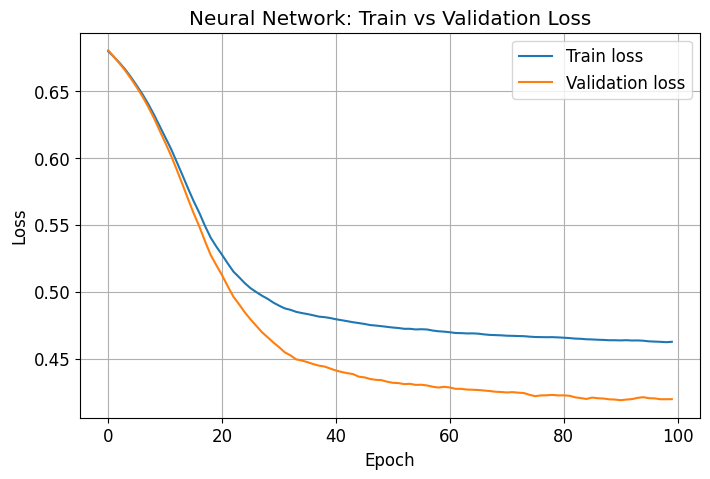

In [4]:
# Training loop

n_epochs   = 100
batch_size = 64
patience   = 10

train_losses = []
val_losses   = []

best_val_loss   = float('inf')
best_state_dict = None
epochs_no_improve = 0

def iterate_minibatches(X_tensor, y_tensor, batch_size):
    N = X_tensor.shape[0]
    indices = torch.randperm(N, device=device)
    for i in range(0, N, batch_size):
        idx = indices[i:i+batch_size]
        yield X_tensor[idx], y_tensor[idx]

for epoch in range(1, n_epochs + 1):
    model.train()

    for xb, yb in iterate_minibatches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        train_logits = model(X_train_tensor)
        epoch_train_loss = criterion(train_logits, y_train_tensor).item()
        val_logits = model(X_val_tensor)
        val_loss = criterion(val_logits, y_val_tensor).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)
    if val_loss < best_val_loss - 1e-4:
        best_val_loss   = val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch:3d} | Train loss: {epoch_train_loss:.4f} | Val loss: {val_loss:.4f} | "
          f"No improve: {epochs_no_improve}")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch} (best val loss = {best_val_loss:.4f})")
        break

# Load best model weights (at lowest validation loss)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)



# Plot train vs validation loss
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Metrics for Neural Network

model.eval()
with torch.no_grad():
    val_logits = model(X_val_tensor)
    val_probs  = torch.sigmoid(val_logits).cpu().numpy().ravel()
    val_pred   = (val_probs >= 0.5).astype(int)

y_val_np = y_val.astype(int)

nn_acc  = accuracy_score(y_val_np, val_pred)
nn_prec = precision_score(y_val_np, val_pred, zero_division=0)
nn_rec  = recall_score(y_val_np, val_pred, zero_division=0)
nn_f1   = f1_score(y_val_np, val_pred, zero_division=0)

print("Neural Network Results")
print(f"Accuracy : {nn_acc:.4f}")
print(f"Precision: {nn_prec:.4f}")
print(f"Recall   : {nn_rec:.4f}")
print(f"F1 Score : {nn_f1:.4f}")


Neural Network Results
Accuracy : 0.7987
Precision: 0.7556
Recall   : 0.6296
F1 Score : 0.6869


In [6]:
# Logistic Regression (sklearn)

log_reg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
)

log_reg.fit(X_train_scaled, y_train)
log_pred = log_reg.predict(X_val_scaled)

log_acc  = accuracy_score(y_val_np, log_pred)
log_prec = precision_score(y_val_np, log_pred, zero_division=0)
log_rec  = recall_score(y_val_np, log_pred, zero_division=0)
log_f1   = f1_score(y_val_np, log_pred, zero_division=0)

print("\nLogistic Regression Results")
print(f"Accuracy : {log_acc:.4f}")
print(f"Precision: {log_prec:.4f}")
print(f"Recall   : {log_rec:.4f}")
print(f"F1 Score : {log_f1:.4f}")



Logistic Regression Results
Accuracy : 0.7792
Precision: 0.7381
Recall   : 0.5741
F1 Score : 0.6458


In [7]:
# Support Vector Machine (SVM)

svm_clf = SVC(
    kernel='rbf',
    C=10,
    gamma=0.01,
    random_state=42
)

svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_val_scaled)

svm_acc  = accuracy_score(y_val_np, svm_pred)
svm_prec = precision_score(y_val_np, svm_pred, zero_division=0)
svm_rec  = recall_score(y_val_np, svm_pred, zero_division=0)
svm_f1   = f1_score(y_val_np, svm_pred, zero_division=0)

print("\nSVM Results (RBF kernel)")
print(f"Accuracy : {svm_acc:.4f}")
print(f"Precision: {svm_prec:.4f}")
print(f"Recall   : {svm_rec:.4f}")
print(f"F1 Score : {svm_f1:.4f}")



SVM Results (RBF kernel)
Accuracy : 0.7922
Precision: 0.7619
Recall   : 0.5926
F1 Score : 0.6667


In [8]:
# Comparison all three models
results = pd.DataFrame({
    "Model": ["Neural Network", "Logistic Regression", "SVM (RBF)"],
    "Accuracy":  [nn_acc,  log_acc,  svm_acc],
    "Precision": [nn_prec, log_prec, svm_prec],
    "Recall":    [nn_rec,  log_rec,  svm_rec],
    "F1 Score":  [nn_f1,   log_f1,   svm_f1]
})

print("\nModel Comparison")
print(results.to_string(index=False))



Model Comparison
              Model  Accuracy  Precision   Recall  F1 Score
     Neural Network  0.798701   0.755556 0.629630  0.686869
Logistic Regression  0.779221   0.738095 0.574074  0.645833
          SVM (RBF)  0.792208   0.761905 0.592593  0.666667


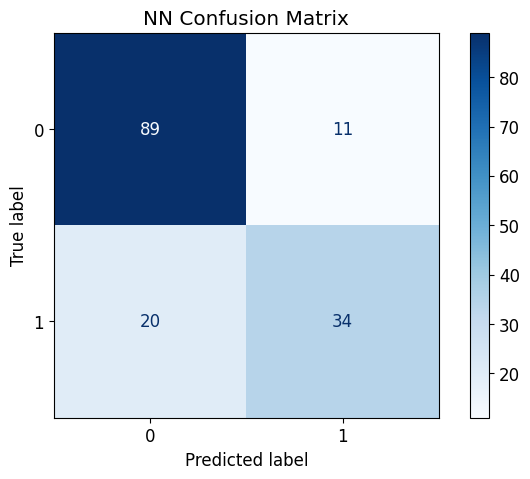

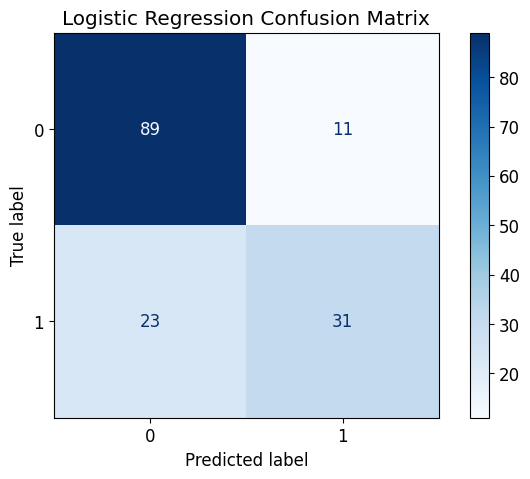

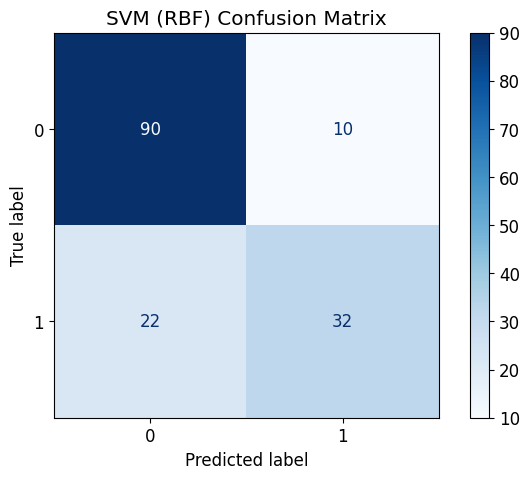

In [9]:
#Confusion matrices plot
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

plot_confusion(y_val_np, val_pred,
               "NN Confusion Matrix")

plot_confusion(y_val_np, log_pred,
               "Logistic Regression Confusion Matrix")

plot_confusion(y_val_np, svm_pred,
               "SVM (RBF) Confusion Matrix")
